In [21]:
import pandas as pd
import numpy as np
import pickle
from tqdm.notebook import tqdm

from utils.Sharp import SharpPortfolio
from utils.Markov import MarkovPortfolio
from utils.Tobin import TobinPortfolio

# Disable jedi autocompleter
%config Completer.use_jedi = False

In [2]:
df = pd.read_csv('results/prediction_table.csv', index_col=0)
pct = pd.read_csv('data/ticker_data_preprocessed.csv', index_col=0)
pct = pct.drop(['sector', '2022-07-29', '2022-07-28', '2022-07-27', '2022-07-26', '2022-07-25'], axis=1)
sp500 = pd.read_csv('data/sp500.csv', index_col=0)['Изм. %'][5:]
bonds = pd.read_csv('data/bonds.csv', index_col=0)['Изм. %'][5:]

In [3]:
sp500 = sp500.apply(lambda x: float(x[:-1].replace(',', '.')) / 100)
bonds = bonds.apply(lambda x: float(x[:-1].replace(',', '.')) / 100)

# Обработка даты 

def month(dates : list):
    new_dates = []
    for d in dates:
        date = d.split()
        months = {'янв.' : '01', 'февр.': '02', 'мар.': '03', 'апр.': '04', 'мая': '05',
                  'июн.' : '06', 'июл.': '07', 'авг.': '08', 'сент.': '09', 'окт.': '10', 'нояб.': '11', 'дек.': '12'}
        date = date[0]+'-'+months[date[1]]+'-'+date[2]
        new_dates.append(date)
    return new_dates

sp500.index = month(sp500.index)

## Создаю словари для каждого метода кластеризации

In [4]:
cols = df.columns[1:]

**общий словарь**: ключ - метод кластеризации, значение - словарь(*ключ - номер кластера, значения - тикеры*)

In [5]:
all_accets = {}
for col in cols:
    accets = {}
    for i in set(df[col].unique()):
        accets[i] = list(df.loc[df[col] == i].index.values)
    all_accets[col] = accets

## Выберу из каждого кластера 2 лучшие акции по значению Шарпа и создам портфель для каждого метода кластеризации

In [6]:
def choose_best_accets(dict_accets, df_pct):
    accets_to_port = []
    for cluster in dict_accets.values():
        if len(cluster)==1:
            accets_to_port.append(cluster[0])
        else:
            dict_with_sharp = {}
            sharp = 0
            first_sharp = -100
            second_sharp = -200
            # считаем Шарпа для каждой акции
            for ticker in cluster:
                tickers_pct = df_pct.loc[df_pct.index == ticker].values
                sharp = (tickers_pct.mean()-0.03)/tickers_pct.std()
                dict_with_sharp[sharp] = ticker

            # выбираем 2 лучших акции
            for sharp in dict_with_sharp.keys():
                if first_sharp < sharp:
                    second_sharp = first_sharp
                    first_sharp = sharp
                elif first_sharp > sharp and second_sharp < sharp:
                    second_sharp = sharp
            accets_to_port.append(dict_with_sharp[first_sharp])
            accets_to_port.append(dict_with_sharp[second_sharp])
    return accets_to_port    

In [7]:
# Сохраняю расчеты в словарь: ключ - название портфеля(метод кластеризации), значение - тикеры
ports = {}
for col in cols:
    ports[col] = choose_best_accets(all_accets[col], pct)

## Найду лучшие методы кластеризации исходя из доходности

Веса в портфеле определяются значением коэффициента Шарпа

In [8]:
bonds.index = pd.to_datetime(bonds.index)
sp500.index = pd.to_datetime(sp500.index)

# Настройка размерности

sp500 = sp500.drop(list(set(sp500.index) - set(bonds.index)))
bonds = bonds.drop(list(set(bonds.index) - set(sp500.index)))

In [9]:
pct_monthly = {}
sp500_monthly = {}
bonds_monthly = {}

pct = pct.T[:-1]
pct.index = pd.to_datetime(pct.index)

In [10]:
# Настройка размерности

pct = pct.drop(list(set(pct.index) - set(bonds.index)))
bonds = bonds.drop(list(set(bonds.index) - set(pct.index)))
sp500 = sp500.drop(list(set(sp500.index) - set(pct.index)))

In [11]:
dates = list((sp500.reset_index().groupby(pd.Grouper(key="index", freq="M")).std()).index)

In [12]:
last_date = dates[0]
pct_monthly[last_date] = pct[(pct.index<=last_date)]
sp500_monthly[last_date] = sp500[(sp500.index<=last_date)]
bonds_monthly[last_date] = bonds[(bonds.index<=last_date)]
for date in dates[1:]:
    pct_monthly[date] = pct[((pct.index>last_date)&(pct.index<=date))]
    sp500_monthly[date] = sp500[((sp500.index>last_date)&(sp500.index<=date))]
    bonds_monthly[date] = bonds[((bonds.index>last_date)&(bonds.index<=date))]
    last_date=date

Для каждого портфеля создаю словарь с доходностями

In [13]:
def create_dict(dates, pct_monthly, tickers):
    d = {}
    for date in dates:
        d[date] = pct_monthly[date][tickers]
    return d

In [14]:
port_names = list(ports.keys())
portfolios = {}
for port in port_names:
    portfolios[port] = create_dict(dates, pct_monthly, ports[port])

В переменной portfolios хранятся словари(каждый метод кластеризации) с доходностями своих тикеров

### Расчет портфелей

1) Выбираем метод кластеризацци
2) Считаем для него оптимизацию

In [15]:
def calc_ports(test, riskless_ret, index, mu, sigma):
    sharp_values, markov_values, tobin_values, traynor_values, qsharp_values = [], [], [], [], []
    # Расчет Шарпа
    sharp = SharpPortfolio(mu, sigma, riskless_ret.mean())
    sh_values = test @ sharp.fit()
    for value in sh_values:
        sharp_values.append(value)

    # Расчет Марковица
    markov = MarkovPortfolio(mu, sigma, index)
    m_values = test @ markov.fit()
    for value in m_values:
        markov_values.append(value)

    # Расчет Тобина

    tobin = TobinPortfolio(mu, sigma, riskless_ret.mean(), index.std())
    #
    tobin.fit()
    #
    tob_values = test @ tobin.fit()
    for value in tob_values:
        tobin_values.append(value)


    df_all_ports = pd.DataFrame({'date':test.index,
                                 'sharp':sharp_values,
                                 'markov':markov_values,
                                 'tobin':tobin_values})
    return df_all_ports

In [22]:
dict_ports = {}
for port in tqdm(list(portfolios.keys())):
    cluster = portfolios[port]
    test = cluster[dates[0]]
    riskless_ret = bonds_monthly[dates[0]]
    index = sp500_monthly[dates[0]]
    mu = test.mean().values
    sigma = test.cov().values

    dict_ports[port] = calc_ports(test, riskless_ret, index, mu, sigma)
    for date in dates:
        test = cluster[date]
        riskless_ret = bonds_monthly[date]
        index = sp500_monthly[date]
        mu = test.mean().values
        sigma = test.cov().values
        layer = calc_ports(test, riskless_ret, index, mu, sigma)
        dict_ports[port] = pd.concat([dict_ports[port], layer])

  0%|          | 0/43 [00:00<?, ?it/s]

-0.2831452060756341 0.0994018349506062
-0.2831452060756341 0.0994018349506062
-0.45701646965062925 -0.14150455945517842
-0.1463378617966716 -0.003421231846674601
-0.1388560274425439 0.3012456065074133
0.5020982185416987 0.38954057149917404
0.056866785715296554 0.05992721108733172
-0.26293409162349 0.044764880346273773
0.2453173663906723 0.2964507535014571
-0.17080787861090632 0.062286190965803116
-0.2886027992932012 -0.272413780566504
0.19776312789564932 0.194331874525548
-0.22524401352812679 -0.2868097121601288
0.7891955560478493 0.5264945652060085
0.35981021958231757 0.07745840905392956
0.5033058521560935 -0.237673713000717
0.24832943405132138 0.17942749680509648
-0.010421105324131654 -0.28338560271870966
0.6992975699025022 0.22067635942500602
0.06453440547334884 0.04754861381473849
-0.0364243241618959 -0.02276160055973704
0.3408035988424436 0.16401082093505773
0.5494758558896634 0.1091174953552649
0.10134064153686365 0.28152303056734934
0.256735976916866 0.5019342696138459
0.2361033

1.4533332449929475 0.13803766925881616
1.2159669180261623 0.2676512437665852
-2.108472054249326 0.3812516934076362
-0.08687302526381625 -0.07414753525494465
0.781901057442123 0.08659029654379621
-1.2462448496717031 0.01860736367542839
-1.5339289456415826 0.4520391655156358
-0.2872698222050725 -0.062402252819964706
-0.8469980491201213 -0.005474395878382271
-1.395954268348484 -0.1127006639058461
-0.26810418187685114 -0.041505512637006026
-1.028047313275665 0.20012197884874755
-0.1971031098156316 -0.02418595415959112
-0.07709980600047674 0.12847260219473286
-0.641362685186965 -0.21147480766653537
0.6227785357852865 0.7673240392346348
-0.003306164309854467 0.4256633956681324
-0.003306164309854467 0.4256633956681324
-0.5295157146604244 -0.25266581755593365
-0.39492364580812855 -0.2468794526944131
-0.18579934406145288 0.22283800183801825
0.3274967866713431 0.23955698390677593
0.13044614216536052 0.12793814580137292
-0.33963190480047173 0.02921505278807175
0.1071487771622456 0.181666024755411

0.37083025114575896 0.12300999519358768
0.02546693442397479 0.14866099760118576
0.3411866883997125 0.4901231662155795
0.36905811686376117 0.11896208967219114
1.015248589023428 0.0018073266071877531
0.06659953414201976 -0.21095629286431564
1.1777144426557973 0.5216481678676766
0.03535325885308546 0.3441953330713253
0.301627662391866 0.16022353429809952
0.6357317685755177 0.23378902425805026
-0.00010746391948947918 0.6577561557724488
0.7866645424226499 0.13488864315605698
0.17832627891468952 -0.057823454327995794
1.5651739276389438 0.6005109709105668
0.035822559190444574 0.47023413068111647
0.5052765421374769 0.045145842876303244
-0.6374679307516609 0.10667605586652786
-0.4398624551531445 -0.038934171997677645
1.3462172025312948 0.12279031859307744
0.7872578229049075 0.15078651078784225
-1.5687681502052915 0.46137912583067664
-0.1686758709743003 -0.16929697789509238
0.7356441578105869 0.22728678641061417
-1.4000810068172183 -0.11254679290939205
-0.9875709400911181 0.5996779005883188
-0.2

0.2528779957995223 0.26591607014054813
-0.37603501049619187 -0.11474924341935985
-0.0773289641457355 0.002178144003563783
-0.2589707973345549 -0.05484618188766789
-0.22381448377898824 -0.17272859854000544
0.10784831740016518 0.11173587474227711
-0.20959386423733406 -0.27490321496101455
0.816503218659339 0.5032801170701782
0.23965255788636622 0.04053918988671413
0.5427909055568229 -0.25508055424366466
-0.10004973849713886 -0.14103251957727445
-0.0277222081183167 -0.3388136580724263
0.686256725197493 0.24097625357683933
0.20684860132613056 0.1924576789514654
-0.15987760454035524 -0.14153511206133348
0.25407209967122674 0.10732373978097531
0.4600027626539472 0.09222672758143875
0.06479243524864287 0.2430436096512284
0.1693738185419808 0.3923305932711753
0.542640743586654 0.17158532503276433
1.2242045935580523 -0.13074912752511267
0.09950871240098964 -0.21782395417295686
1.1286305593419885 0.4345322795804791
-0.00945290096649384 0.3060988833928783
0.2894268149222977 0.15436945149707493
0.7

0.7595245617337915 0.06730447067684808
-1.4704945646518723 -0.011895099560516206
-1.9059628545197917 0.4213996633536703
-0.2792045925343457 -0.05118691772195138
-0.9034352208371608 0.0454164792243179
-1.6818134187259168 -0.15770178881899638
-0.2721162905402144 -0.003879572347393836
-1.221998319251658 0.24032828380779142
-0.20734424234465365 -0.047444436908269924
-0.052392615996546314 0.17401969284827914
-0.6479308684390052 -0.1772629060145917
0.6083763632840125 0.7811570287794786
-0.22275813262664737 0.15010844174306345
-0.22275813262664737 0.15010844174306345
-0.51945270467787 -0.20029537984575238
-0.21577231797459145 -0.006606969577683217
-0.18465256738956243 0.27005005952525984
0.47840214217834237 0.38985234519043405
0.2650189162862878 0.25951913023287687
-0.28883758200203247 0.006476241640774392
0.060371581363088074 0.12859560410078036
-0.3069202760061205 -0.08959322786372756
-0.2632630290899769 -0.20093591750967213
0.25353304768614093 0.25828415724075576
-0.17739676164292126 -0.24

0.12363936715121034 -0.19334407231781936
1.2990496338850859 0.5128425479990373
0.013749455193650919 0.35480937562107384
0.2540911368540714 0.10121892849932713
0.6320811318907759 0.12387413058089691
-0.38687768368316106 0.7050546205131609
0.8649656581328584 -0.006092968123935571
0.12784741432699928 -0.18758928641886816
1.4901514066147419 0.5743485971159324
-0.22217687804672376 0.38368690112894016
0.6786485436216152 0.02477001543973712
-0.897462089061948 0.18418244438404205
-0.6752036521238516 -0.06711525865978461
1.5608383521132125 0.13587705021790009
1.0255254691060547 0.08557973727009927
-2.0167867441125953 0.37598242921959635
-0.06206055110204347 -0.04309526484970258
0.7819887598127858 0.03657394591797553
-1.3795461210551252 0.032192695764183175
-2.1632117083905364 0.45098029032079645
-0.3665827249971413 -0.12803581682585266
-0.9207682679925612 0.044149816900486
-1.6307631727568221 -0.10510103168593798
-0.4031204213555834 -0.11938225416491778
-1.2451900485978689 0.23300992798988815
-

-0.2688564262606289 -0.23570193406166098
0.1883378304455591 0.17919730125161523
-0.2076696207247239 -0.2556230373590995
0.6538576488942239 0.4850003161279666
0.430358296404314 0.233914394974385
0.277711768661636 -0.3484062242836466
0.08936606211596389 0.056930431317480566
0.106986060601091 -0.09898300289409472
0.3381562501177678 0.056087467848156124
0.1273833306234069 0.1312023017918813
-0.0484688786672864 -0.03621497219300952
0.20867700249574309 0.07200819358724206
0.3899833328377846 0.11462825723220917
0.26023187476181336 0.4019682343100904
0.379485087783206 0.5327313598622528
0.43760035424994953 0.17818977937074912
1.0549860929419488 0.043481045360532405
0.05845610272602832 -0.21033994168459832
1.133679320325323 0.529108797224376
0.13908948285810477 0.463561326065771
0.21651955067376835 0.0911375352564693
0.5177972488266891 0.1737591923042418
0.18517957457653697 0.9820327582859788
0.7442356339835212 0.09733745748292279
0.02100928101706169 -0.22952772319482442
1.7145154787434802 0.76

-0.16972217426382838 0.04364027885080997
-0.874126591955029 0.21698772171965722
-0.28099283009031706 -0.1097598127841676
-0.008062950264551609 0.1650879526918904
-0.5241642296002132 -0.17724410974181534
0.4349759500835155 0.5501079429328929
-0.08010972649565748 0.41935620375880633
-0.08010972649565748 0.41935620375880633
-0.5879051201236882 -0.23263763499876708
-0.23429803859163884 -0.07885469027821991
-0.24595428590223653 0.14727871522286026
0.527525774476316 0.43553483846169366
0.047699789672969437 0.06052611467126494
-0.2691411679696823 0.06740325773271434
0.10980892384708657 0.1563378529598125
-0.39770316006729545 -0.19453670259019526
-0.1948933407357752 -0.159368116277088
0.15590880222772063 0.15993275469435908
-0.1771647526304895 -0.24556250638592284
0.6717306352574609 0.4393382817628612
0.6756774814290005 0.4292080142148716
0.5739686905328525 -0.18419266593364977
0.12741640887553785 0.08994036069148002
-0.08610054545547041 -0.3516500103331507
0.7328480528492193 0.234664761109527

/cephfs/projects/psoker/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


-0.06043630730901388 0.23933672810556347
-0.30600420075483126 -0.04930700635298544
-0.27554510401011956 -0.14095362449012233
-0.0478033146388306 0.2871940503030868
0.4037992833150895 0.3455622545916666
0.18647918255122525 0.19275246855271744
-0.190304724086247 0.10028092549328653
0.16966979932060222 0.21591968896758934
-0.02016733645249853 0.12577366168846615
-0.3064687953180431 -0.27400353738490324
0.22704862001414233 0.22988417800532662
-0.20906237931241464 -0.2575680793429388
0.6759372823522602 0.4959215394364301
0.5238784326350496 0.34559475526119077
0.3903856365332826 -0.27630552881077264
0.024735008366278538 0.005437942856206621
0.0716207262245211 -0.12347158509149415
0.30096038912256895 0.0067400316355282364
0.10651695545130851 0.11034147909548273
-0.05937350563140205 -0.045628307707927765
0.24516157588272347 0.10848493970748226
0.3089886841553232 0.05865073365114815
0.11451320456842795 0.28933622656060304
0.42594482174231335 0.5778995157975739
0.345212947064516 0.10954574234193

0.8964224421665484 0.2087717288380706
-2.0989715290243334 0.34483841303876533
-0.16648377469368986 -0.16232011326172474
0.6347601900405658 0.12825309158783488
-1.173374300329853 -0.02029427177409609
-1.194471019876029 0.5290691407418459
-0.39532351786680925 -0.19864265229934244
-0.7623579367356815 -0.02192585063171194
-1.376266554331503 -0.08433926227554082
-0.21759819457532564 -0.018585571255556724
-0.9331150677525393 0.15332635983829443
-0.22153599693279166 -0.0652069465397951
-0.058213784067190355 0.11060286863323707
-0.5021500583658731 -0.1606196578255813
0.48775739488145864 0.5826858113836101
-0.22947555765943461 0.09837927793052051
-0.22947555765943461 0.09837927793052051
-0.3627876165406636 -0.0856670643261314
-0.3025807835503625 -0.1667788219578297
-0.21466736416961302 0.14602747433846408
0.35986225411112155 0.2625019072130856
0.13514800351925418 0.1438751742540447
-0.34032095838403353 -0.04236342605773203
-0.13033490892799499 -0.07662036304245762
-0.07737342294015274 0.0937074

-10000000 -0.005135215909725
-10000000 -0.0014812744599003553
-10000000 0.6623784485304637
-10000000 0.20061523245173438
-10000000 -0.07817942582916326
-10000000 0.7803124507475785
-10000000 0.5509161064528099
-10000000 -0.03068076903189814
-10000000 0.16833065975145253
-10000000 -0.06981622295803384
-10000000 0.05682151641932242
-10000000 0.3190427810557512
-10000000 0.6109177668045322
-10000000 -0.1297854747870337
-10000000 0.07406221508358031
-10000000 -0.022770695855022623
-10000000 0.3429095213730206
-10000000 -0.0814857958579834
-10000000 -0.17577482341335374
-10000000 -0.21824295306349556
-10000000 0.03797334645999768
-10000000 0.1456614938643552
-10000000 -0.0441099091988831
-10000000 0.19584226962843293
-10000000 -0.03487201242435264
-10000000 0.6192548773824412
-0.13844662313991482 0.20509104832245284
-0.13844662313991482 0.20509104832245284
-0.4094062470122045 -0.12842092091341323
-0.2914760891976241 -0.1483511155147988
-0.14156647981539858 0.19730031983548615
0.407223530916

0.8391750794037496 0.37530294213086285
-0.0926190533317835 -0.08699550595260964
-0.13737648252882545 -0.11827006743572653
0.3828416318971387 0.20874901227116524
0.7308891185919935 0.299518217425228
-0.14695815780279675 0.06862797567328818
0.2187202517617758 0.46519182287186706
0.36111481468310275 -0.01604086308190257
1.2403805790168543 -0.1774225104393854
0.13109887435736658 -0.20375007782385376
1.1660601088690932 0.44323199815270387
-0.09533094332143963 0.21723515420410378
0.26514931479786735 0.12223340333363819
0.6823590585546927 0.16594664705565276
-0.3590051893510786 0.564636233384048
0.8951904167789564 0.014430066289591474
0.2120288257052841 -0.08375852620812421
1.4209468852030607 0.5103183130760951
-0.3050883895229856 0.25027555024054177
0.7677623685364305 0.08002171765411398
-0.7749399660810614 0.25647815057180723
-0.6957164491534114 -0.020989186036335997
1.9067705650467082 0.2004457635493452
1.1412702841072795 0.23358376846360746
-1.7148115405025561 0.16160466847739416
-0.12979

-0.15665658998475315 0.19597183684646535
-0.40203062544915824 -0.11052976297797482
-0.3136896491934792 -0.18385548188664136
-0.22248209329400545 0.137674311538538
0.40631242622963565 0.32371044817637556
0.10091500918488937 0.11041813724967427
-0.21819774224189112 0.11941222077990374
-0.02745590301252027 0.031456603983346904
-0.06617714305012307 0.13753875992392153
-0.31432891075587555 -0.27760945538149556
0.17053588805285844 0.15328126430670774
-0.24859446475143326 -0.304138877558741
0.6465660196018582 0.42248302756074707
0.4120106690717493 0.20854830570856495
0.4330320603251076 -0.2272054800970245
0.14312265982532893 0.11493245801542584
-0.13015053691904574 -0.35268395213678233
0.6997632309346618 0.2934269785840189
-0.0024079115983515163 0.001391151666274555
-0.15124390465973764 -0.13620622289717163
0.31947014189914597 0.18364371128783674
0.5168874443376331 0.20077191920550158
0.03571615768273622 0.20628297758789937
0.2624769441258626 0.4337257396803891
0.22564178476905772 -0.02946146

In [23]:
df_res_sharp = pd.DataFrame([])
df_res_markov = pd.DataFrame([])
df_res_tobin = pd.DataFrame([])
columns = []

for i, (k, v) in enumerate(dict_ports.items()):
    col_names = v.columns
    df_loc_sharp = pd.DataFrame(data=v[col_names[1]].values, index=v[col_names[0]].values, columns = [k])
    df_res_sharp = pd.concat([df_res_sharp, df_loc_sharp], axis=1)
    df_loc_markov = pd.DataFrame(data=v[col_names[2]].values, index=v[col_names[0]].values, columns = [k])
    df_res_markov = pd.concat([df_res_markov, df_loc_markov], axis=1)
    df_loc_tobin = pd.DataFrame(data=v[col_names[3]].values, index=v[col_names[0]].values, columns = [k])
    df_res_tobin = pd.concat([df_res_tobin, df_loc_tobin], axis=1)
    columns.append(columns)

In [24]:
df_res_sharp['sp500']=sp500
df_res_markov['sp500']=sp500
df_res_tobin['sp500']=sp500

df_res_sharp.to_csv('results/df_res_sharp.csv')
df_res_markov.to_csv('results/df_res_markov.csv')
df_res_tobin.to_csv('results/df_res_tobin.csv')

In [25]:
df_real_sharp = (df_res_sharp + 1).cumprod()
df_real_markov = (df_res_markov + 1).cumprod()
df_real_tobin = (df_res_tobin + 1).cumprod()

df_real_sharp.to_csv('results/df_real_sharp.csv')
df_real_markov.to_csv('results/df_real_markov.csv')
df_real_tobin.to_csv('results/df_real_tobin.csv')

In [74]:
df_all_ports_pct

,original_n,deco_pca_Kmean,deco_pca_Agglo,deco_pca_MiniB,deco_pca_Gauss,deco_pca_Spect,deco_fast_Kmean,deco_fast_Agglo,deco_fast_MiniB,deco_fast_Gauss,...,neur_lstm_Gauss,neur_lstm_Spect,orig__Kmean,orig__Agglo,orig__MiniB,orig__Gauss,orig__Spect,orig__origi,orig__rando,sp500
2018-01-03,0.001552,0.051913,0.051913,0.051913,0.051913,0.051913,0.051913,-0.010233,0.051913,0.051913,...,-0.011058,0.051913,0.051913,-0.010233,0.019794,0.022838,-0.027595,0.001552,0.065814,0.0381
2018-01-05,0.019330,-0.019802,-0.019802,-0.019802,-0.019802,-0.019802,-0.019802,0.006230,-0.019802,-0.019802,...,-0.006250,-0.019802,-0.019802,0.006230,0.021203,0.005545,0.011284,0.019330,0.008474,-0.0217
2018-01-08,0.040931,0.033670,0.033670,0.033670,0.033670,0.033670,0.033670,0.062638,0.033670,0.033670,...,-0.003145,0.033670,0.033670,0.062638,0.009810,0.033904,-0.002071,0.040931,0.030641,0.0036
2018-01-10,0.073260,0.011844,0.011844,0.011844,0.011844,0.011844,0.011844,0.003326,0.011844,0.011844,...,0.006240,0.011844,0.011844,0.003326,0.015336,0.065795,-0.012093,0.073260,0.007840,-0.0038
2018-01-11,-0.006485,0.015050,0.015050,0.015050,0.015050,0.015050,0.015050,0.009409,0.015050,0.015050,...,0.009302,0.015050,0.015050,0.009409,0.022210,-0.005640,0.023658,-0.006485,0.001788,-0.0444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-15,-0.010207,0.059707,0.059707,0.059707,0.059707,0.059707,0.059707,0.034742,0.059707,0.059707,...,-0.010207,0.034742,0.059707,0.059707,0.081989,0.059707,0.059707,-0.010207,0.059707,-0.0245
2022-07-18,0.059104,0.038895,0.038895,0.038895,0.038895,0.038895,0.038895,0.026909,0.038895,0.038895,...,0.059104,0.026909,0.038895,0.038895,0.009571,0.038895,0.038895,0.059104,0.038895,0.0150
2022-07-19,0.033474,0.053884,0.053884,0.053884,0.053884,0.053884,0.053884,0.032106,0.053884,0.053884,...,0.033474,0.032106,0.053884,0.053884,0.056097,0.053884,0.053884,0.033474,0.053884,-0.0140
2022-07-20,0.025734,0.032537,0.032537,0.032537,0.032537,0.032537,0.032537,0.059698,0.032537,0.032537,...,0.025734,0.059698,0.032537,0.032537,0.073451,0.032537,0.032537,0.025734,0.032537,-0.0126


<AxesSubplot:>

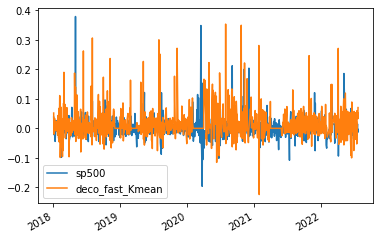

In [75]:
df_all_ports_pct[['sp500', 'deco_fast_Kmean']].plot()

## Метрики Sharp

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates

from scipy.stats import norm

import functools

## Поиск метрик

In [27]:
df_all_ports_pct = pd.read_csv('results/df_res_sharp.csv', index_col=0)
df_all_ports_pct.index = pd.to_datetime(df_all_ports_pct.index)
days = df_all_ports_pct.index

## Доходность

In [28]:
ret_ports = df_all_ports_pct.mean()#находим доходности портфелей

## Безрисковый актив

In [29]:
df_b = pd.read_csv(r'data/bonds.csv', decimal=",")
df_bond = pd.DataFrame()

# Найти среднюю цену за месяц и поделить её на 100
df_bond['date'] = df_b['Дата']
df_bond['цена'] = df_b['Цена']/100
df_bond.date = pd.to_datetime(df_bond.date)
df_bond.set_index('date', inplace = True)

df_bond = df_bond.mean()

## Риск портфеля

In [30]:
risk_ports = df_all_ports_pct.std()

## Beta портфеля

In [31]:
var_ports = df_all_ports_pct.var()
cov_ports = df_all_ports_pct.cov()

In [32]:
# Beta = cov(ret_port;ret_IMOEX)/var(IMOEX), beta считается, только для портфелей, не для индекса
beta = cov_ports['sp500']/var_ports['sp500']
beta = beta.to_frame()
beta_ports = (cov_ports['sp500']/var_ports['sp500']).to_frame().T.rename({'sp500':'Beta'})

## Коэффициент VaR

In [33]:
mean_for_var = df_all_ports_pct.mean()
std_for_var = df_all_ports_pct.std()

In [34]:
l_pr_values = df_all_ports_pct.iloc[-1, :].values

In [35]:
var = l_pr_values*(1+norm.ppf(0.001, mean_for_var, std_for_var))/l_pr_values-1
var = pd.DataFrame(data=var.reshape(1,-1), columns=mean_for_var.index, index=['VaR'])
var

,original_n,deco_pca_Kmean,deco_pca_Agglo,deco_pca_MiniB,deco_pca_Gauss,deco_pca_Spect,deco_fast_Kmean,deco_fast_Agglo,deco_fast_MiniB,deco_fast_Gauss,...,neur_lstm_Gauss,neur_lstm_Spect,orig__Kmean,orig__Agglo,orig__MiniB,orig__Gauss,orig__Spect,orig__origi,orig__rando,sp500
VaR,-0.069293,-0.06964,-0.082701,-0.065872,-0.068442,-0.072928,-0.070099,-0.0783,-0.07192,-0.072862,...,-0.122632,-0.083559,-0.066168,-0.087908,-0.061946,-0.063723,-0.073511,-0.069293,-0.07907,-0.108396


## Коэффициент Шарпа

In [36]:
std_ports = df_all_ports_pct.std()

sharp_ports = (ret_ports - df_bond['цена'])/std_ports

## Просадка и восстановление

In [37]:
def find_max_drawdown(prices):

    max_price = prices.iloc[0]
    curr_drawdown = 0
    max_drawdown = 0
    curr_left = 0
    left = 0
    right = 0
    for i in range(0, len(prices)):
        curr_drawdown = (prices.iloc[i] / max_price - 1) * 100
        # print(type(curr_drawdown))
        if curr_drawdown < max_drawdown:
            max_drawdown = curr_drawdown
            left = curr_left
            right = i
        if prices.iloc[i] > max_price:
            max_price = prices.iloc[i]
            curr_left = i
    return max_drawdown

In [38]:
def find_max_recovery(prices):
    
    def calc_growth(prices):

        growth = []
        past_p = 0
        for p in prices:
            if past_p:
                growth.append(p - past_p)
            past_p = p
        return growth

    growth = calc_growth(prices)
    s = 0
    left = 0
    right = 0
    curr_left = 0
    max_recovery = 0
    for i in range(0, len(growth)):
        if not s:
            curr_left = i
        s += growth[i]
        if s > 0:
            s = 0
            if max_recovery < (i - curr_left):
                max_recovery = i - curr_left
                left = curr_left
                right = i

    return max_recovery

In [39]:
recovery = []
drawdown = []
for i in range(len(df_all_ports_pct.columns)):
    recovery.append(find_max_recovery(df_all_ports_pct.iloc[:,i]))
    drawdown.append(find_max_drawdown(df_all_ports_pct.iloc[:,i]))

In [40]:
risk = pd.DataFrame(risk_ports, columns =['Risk']).T
ret = pd.DataFrame(ret_ports, columns =['Ret']).T
sharp = pd.DataFrame(sharp_ports, columns =['Sharp']).T
rec = pd.Series(recovery)
rec = pd.DataFrame(rec, columns =['Recovery']).T
drawd = pd.Series(drawdown)
drawd = pd.DataFrame(drawd, columns =['Drawdown']).T

In [41]:
all_metrics = pd.concat([var,beta_ports, risk, ret, sharp])

rec.set_axis(list(all_metrics.columns), axis=1, inplace=True)
drawd.set_axis(list(all_metrics.columns), axis=1, inplace=True)

all_metrics = all_metrics.append(rec)
all_metrics = all_metrics.append(drawd)

all_metrics = all_metrics.T
all_metrics['Method'] = ['Sharp']*len(all_metrics)

## Метрики Markov

## Поиск метрик

In [42]:
df_all_ports_pct = pd.read_csv('results/df_res_markov.csv', index_col=0)
df_all_ports_pct.index = pd.to_datetime(df_all_ports_pct.index)
days = df_all_ports_pct.index

## Доходность

In [43]:
ret_ports = df_all_ports_pct.mean()#находим доходности портфелей

## Риск портфеля

In [44]:
risk_ports = df_all_ports_pct.std()

## Beta портфеля

In [45]:
var_ports = df_all_ports_pct.var()
cov_ports = df_all_ports_pct.cov()

In [46]:
# Beta = cov(ret_port;ret_IMOEX)/var(IMOEX), beta считается, только для портфелей, не для индекса
beta = cov_ports['sp500']/var_ports['sp500']
beta = beta.to_frame()
beta_ports = (cov_ports['sp500']/var_ports['sp500']).to_frame().T.rename({'sp500':'Beta'})

## Коэффициент VaR

In [47]:
mean_for_var = df_all_ports_pct.mean()
std_for_var = df_all_ports_pct.std()

In [48]:
l_pr_values = df_all_ports_pct.iloc[-1, :].values

In [49]:
var = l_pr_values*(1+norm.ppf(0.001, mean_for_var, std_for_var))/l_pr_values-1
var = pd.DataFrame(data=var.reshape(1,-1), columns=mean_for_var.index, index=['VaR'])
var

,original_n,deco_pca_Kmean,deco_pca_Agglo,deco_pca_MiniB,deco_pca_Gauss,deco_pca_Spect,deco_fast_Kmean,deco_fast_Agglo,deco_fast_MiniB,deco_fast_Gauss,...,neur_lstm_Gauss,neur_lstm_Spect,orig__Kmean,orig__Agglo,orig__MiniB,orig__Gauss,orig__Spect,orig__origi,orig__rando,sp500
VaR,-0.083088,-0.082282,-0.086372,-0.080602,-0.083518,-0.084464,-0.083543,-0.080083,-0.085367,-0.088872,...,-0.047343,-0.086977,-0.082571,-0.085798,-0.083106,-0.078336,-0.081935,-0.083088,-0.082028,-0.108396


## Коэффициент Шарпа

In [50]:
std_ports = df_all_ports_pct.std()
sharp_ports = (ret_ports - df_bond['цена'])/std_ports

## Просадка и восстановление

In [51]:
recovery = []
drawdown = []
for i in range(len(df_all_ports_pct.columns)):
    recovery.append(find_max_recovery(df_all_ports_pct.iloc[:,i]))
    drawdown.append(find_max_drawdown(df_all_ports_pct.iloc[:,i]))

In [52]:
risk = pd.DataFrame(risk_ports, columns =['Risk']).T
ret = pd.DataFrame(ret_ports, columns =['Ret']).T
sharp = pd.DataFrame(sharp_ports, columns =['Sharp']).T
rec = pd.Series(recovery)
rec = pd.DataFrame(rec, columns =['Recovery']).T
drawd = pd.Series(drawdown)
drawd = pd.DataFrame(drawd, columns =['Drawdown']).T

In [53]:
markov_metrics = pd.concat([var,beta_ports, risk, ret, sharp])

rec.set_axis(list(markov_metrics.columns), axis=1, inplace=True)
drawd.set_axis(list(markov_metrics.columns), axis=1, inplace=True)

markov_metrics = markov_metrics.append(rec)
markov_metrics = markov_metrics.append(drawd)

markov_metrics = markov_metrics.T
markov_metrics['Method'] = ['Markov']*len(all_metrics)

In [54]:
all_metrics = pd.concat([all_metrics, markov_metrics])

## Метрики Tobin

## Поиск метрик

In [55]:
df_all_ports_pct = pd.read_csv('results/df_res_tobin.csv', index_col=0)
df_all_ports_pct.index = pd.to_datetime(df_all_ports_pct.index)
days = df_all_ports_pct.index

## Доходность

In [56]:
ret_ports = df_all_ports_pct.mean()#находим доходности портфелей

## Риск портфеля

In [57]:
risk_ports = df_all_ports_pct.std()

## Beta портфеля

In [58]:
var_ports = df_all_ports_pct.var()
cov_ports = df_all_ports_pct.cov()

In [59]:
# Beta = cov(ret_port;ret_IMOEX)/var(IMOEX), beta считается, только для портфелей, не для индекса
beta = cov_ports['sp500']/var_ports['sp500']
beta = beta.to_frame()
beta_ports = (cov_ports['sp500']/var_ports['sp500']).to_frame().T.rename({'sp500':'Beta'})

## Коэффициент VaR

In [60]:
mean_for_var = df_all_ports_pct.mean()
std_for_var = df_all_ports_pct.std()

In [61]:
l_pr_values = df_all_ports_pct.iloc[-1, :].values

In [62]:
var = l_pr_values*(1+norm.ppf(0.001, mean_for_var, std_for_var))/l_pr_values-1
var = pd.DataFrame(data=var.reshape(1,-1), columns=mean_for_var.index, index=['VaR'])
var

,original_n,deco_pca_Kmean,deco_pca_Agglo,deco_pca_MiniB,deco_pca_Gauss,deco_pca_Spect,deco_fast_Kmean,deco_fast_Agglo,deco_fast_MiniB,deco_fast_Gauss,...,neur_lstm_Gauss,neur_lstm_Spect,orig__Kmean,orig__Agglo,orig__MiniB,orig__Gauss,orig__Spect,orig__origi,orig__rando,sp500
VaR,-0.137228,-0.135844,-0.127698,-0.126594,-0.135011,-0.144219,-0.141307,-0.128967,-0.136049,-0.145637,...,-0.123954,-0.12884,-0.135581,-0.127363,-0.136278,-0.139065,-0.139585,-0.137228,-0.128086,-0.108396


## Коэффициент Шарпа

In [63]:
std_ports = df_all_ports_pct.std()
sharp_ports = (ret_ports - df_bond['цена'])/std_ports

## Просадка и восстановление

In [64]:
recovery = []
drawdown = []
for i in range(len(df_all_ports_pct.columns)):
    recovery.append(find_max_recovery(df_all_ports_pct.iloc[:,i]))
    drawdown.append(find_max_drawdown(df_all_ports_pct.iloc[:,i]))

In [65]:
risk = pd.DataFrame(risk_ports, columns =['Risk']).T
ret = pd.DataFrame(ret_ports, columns =['Ret']).T
sharp = pd.DataFrame(sharp_ports, columns =['Sharp']).T
rec = pd.Series(recovery)
rec = pd.DataFrame(rec, columns =['Recovery']).T
drawd = pd.Series(drawdown)
drawd = pd.DataFrame(drawd, columns =['Drawdown']).T

In [66]:
tobin_metrics = pd.concat([var,beta_ports, risk, ret, sharp])

rec.set_axis(list(tobin_metrics.columns), axis=1, inplace=True)
drawd.set_axis(list(tobin_metrics.columns), axis=1, inplace=True)

tobin_metrics = tobin_metrics.append(rec)
tobin_metrics = tobin_metrics.append(drawd)

tobin_metrics = tobin_metrics.T
tobin_metrics['Method'] = ['Tobin']*len(tobin_metrics)

In [67]:
all_metrics = pd.concat([all_metrics, tobin_metrics])

## Сохранение результата

In [68]:
all_metrics.to_excel('results/metrics.xlsx')